In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.special import inv_boxcox

import re

In [2]:
fifa_data = pd.read_csv('fifa21_male2.csv')
fifa_data.columns

Index(['ID', 'Name', 'Age', 'OVA', 'Nationality', 'Club', 'BOV', 'BP',
       'Position', 'Player Photo',
       ...
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'GK', 'Gender'],
      dtype='object', length=107)

## 1. choosing the columns we want

In [6]:
data = fifa_data[['ID',
 'Name',
 'Age',
 'OVA',
 'BOV',
 'POT',
 'Height',
 'Weight',
 'Growth',
 'Joined',
 'Value',
 'Wage',
 'Release Clause',
 'Skill',
 'Total Stats',
 'Base Stats',
 'Composure',
 'Jumping','Stamina','Strength','Acceleration','Sprint Speed']]
data

,ID,Name,Age,OVA,BOV,POT,Height,Weight,Growth,Joined,...,Release Clause,Skill,Total Stats,Base Stats,Composure,Jumping,Stamina,Strength,Acceleration,Sprint Speed
0,2,G. Pasquale,33,69,71,69,"6'0""",181lbs,0,"Jul 1, 2008",...,€0,338,1929,408,NaN,68.0,69,68,68,74
1,16,Luis García,37,71,70,71,"5'10""",143lbs,0,"Jul 19, 2014",...,€1.1M,369,1906,385,79.0,54.0,64,60,56,50
2,27,J. Cole,33,71,71,71,"5'9""",161lbs,0,"Jan 7, 2016",...,€0,387,1770,354,NaN,58.0,29,56,48,42
3,36,D. Yorke,36,68,70,82,"5'11""",165lbs,14,NaN,...,€0,255,1348,369,NaN,NaN,51,66,59,62
4,41,Iniesta,36,81,82,81,"5'7""",150lbs,0,"Jul 16, 2018",...,€7.2M,408,2014,420,89.0,40.0,58,62,61,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17120,259088,A. Medioub,22,64,66,69,"6'6""",165lbs,5,"Sep 29, 2020",...,€0,193,1367,302,46.0,70.0,59,74,52,55
17121,259090,W. Rickard,18,56,58,66,"5'10""",170lbs,10,"Aug 20, 2020",...,€273K,264,1529,319,46.0,62.0,53,57,61,63
17122,259091,C. Barrett,18,56,56,67,"5'9""",154lbs,11,"Aug 20, 2020",...,€273K,212,1430,303,43.0,61.0,53,54,66,61
17123,259101,J. Gazibegović,20,62,62,73,"5'9""",148lbs,11,"Sep 30, 2020",...,€784K,258,1579,335,54.0,72.0,57,48,72,70


In [7]:
num = data.select_dtypes(include = np.number)
num

,ID,Age,OVA,BOV,POT,Growth,Skill,Total Stats,Base Stats,Composure,Jumping,Stamina,Strength,Acceleration,Sprint Speed
0,2,33,69,71,69,0,338,1929,408,NaN,68.0,69,68,68,74
1,16,37,71,70,71,0,369,1906,385,79.0,54.0,64,60,56,50
2,27,33,71,71,71,0,387,1770,354,NaN,58.0,29,56,48,42
3,36,36,68,70,82,14,255,1348,369,NaN,NaN,51,66,59,62
4,41,36,81,82,81,0,408,2014,420,89.0,40.0,58,62,61,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17120,259088,22,64,66,69,5,193,1367,302,46.0,70.0,59,74,52,55
17121,259090,18,56,58,66,10,264,1529,319,46.0,62.0,53,57,61,63
17122,259091,18,56,56,67,11,212,1430,303,43.0,61.0,53,54,66,61
17123,259101,20,62,62,73,11,258,1579,335,54.0,72.0,57,48,72,70


# Standardizing

In [15]:
def cleaning_0(data): 
    cols = [col_name.lower().replace(' ', '_') for col_name in data.columns]
    data.columns = cols
    question1 = input("Are there columns to drop? (Y/N)")
    while question1 == "Y":
        which_one = input("Enter column to drop (None: script runs further):")
        if which_one != "None":
            data = data.drop([which_one], axis=1)
            question2 = input("Are there more columns to drop? (Y/N)")
            if question2 == "Y":
                question1 = question2
            elif question2 == "N":
                print("No more columns dropped.")
                break
            else:
                print("Error: input must be Y or N!")
                question2 = input("Are there more columns to drop? (Y/N)")   
        elif which_one == "None":
            break   
    if question1 == "N":
        print("No columns dropped.")
    elif question1 != "Y" and question1 != "N":
        print("Error: input must be Y or N!")
        question1 = input("Are there columns to drop? (Y/N)")
        while question1 == "Y":
            which_one = input("Enter column to drop (None: continue without dropping or random key: repeat question):")
            if which_one == "None":
                break
            elif which_one != "None":
                data = data.drop([which_one], axis=1)
                question2 = input("Are there more columns to drop? (Y/N)")
                if question2 == "Y":
                    question1 = question2
                elif question2 == "N":
                    print("No more columns dropped.")
                    break
                else:
                    print("Error: input must be Y or N!")
                    question2 = input("Are there more columns to drop? (Y/N)")
        if question1 == "N":
            print("No columns dropped.")
        elif question1 != "Y" and question1 != "N":
            ("Error: input must be Y or N! To drop columns re-run function. Standardisation nevertheless complete")
            question1 = input("Are there columns to drop? (Y/N)")
    return data

In [16]:
cleaning_0(data)        # I removed the command for alphabetical order from my function, because it was harder to read the data with it

No columns dropped.


,id,name,age,ova,pot,growth,bov,total_stats,base_stats,a/w,...,interceptions,composure,penalties,mentality,positioning,vision,ir,value,wage,release_clause
0,2,G. Pasquale,33,69,69,0,71,1929,408,Medium,...,69.0,NaN,50,320,63.0,66.0,2 ★,€625K,€7K,€0
1,16,Luis García,37,71,71,0,70,1906,385,Medium,...,71.0,79.0,75,362,72.0,73.0,1 ★,€600K,€7K,€1.1M
2,27,J. Cole,33,71,71,0,71,1770,354,Medium,...,39.0,NaN,66,317,69.0,74.0,2 ★,€1.1M,€15K,€0
3,36,D. Yorke,36,68,82,14,70,1348,369,NaN,...,70.0,NaN,70,271,72.0,NaN,1 ★,€0,€0,€0
4,41,Iniesta,36,81,81,0,82,2014,420,High,...,70.0,89.0,71,370,78.0,93.0,4 ★,€5.5M,€12K,€7.2M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17120,259088,A. Medioub,22,64,69,5,66,1367,302,Medium,...,58.0,46.0,39,218,23.0,29.0,1 ★,€550K,€2K,€0
17121,259090,W. Rickard,18,56,66,10,58,1529,319,Medium,...,50.0,46.0,50,259,55.0,53.0,1 ★,€130K,€3K,€273K
17122,259091,C. Barrett,18,56,67,11,56,1430,303,Medium,...,55.0,43.0,49,256,49.0,45.0,1 ★,€130K,€2K,€273K
17123,259101,J. Gazibegović,20,62,73,11,62,1579,335,High,...,58.0,54.0,36,257,46.0,56.0,1 ★,€475K,€3K,€784K


In [33]:
# a fast way to produce a heatmap

def fast_heatmap(data):
    mask = np.zeros_like(data.corr())
    mask[np.triu_indices_from(mask)] = True 
    fig, ax = plt.subplots(figsize=(10, 8))
    ax = sns.heatmap(data.corr(), mask=mask, annot=True)
    return ax

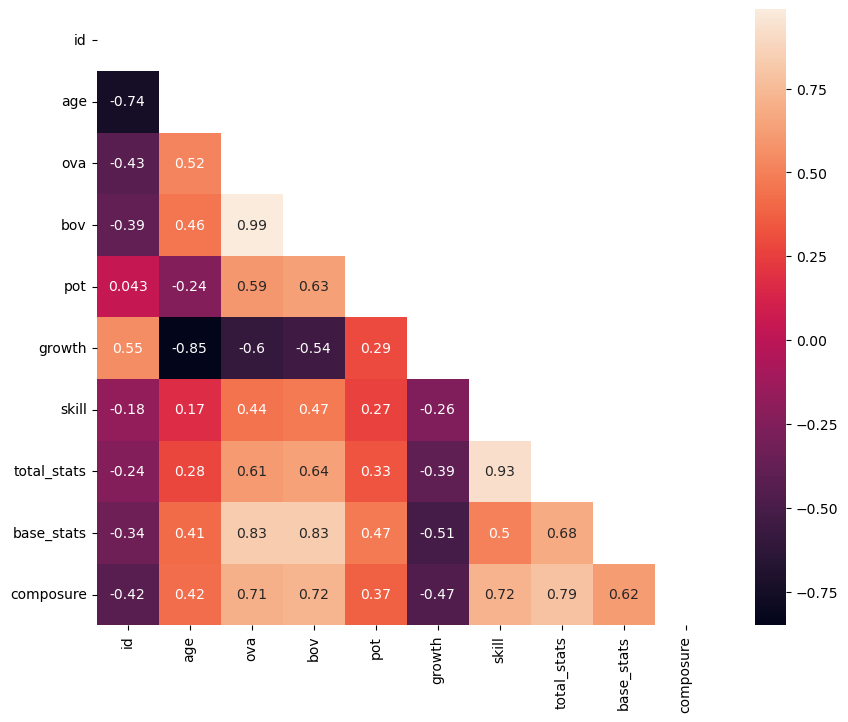

In [34]:
v = fast_heatmap(num)
plt.show(v)

In [12]:
cleaning_0(num)

No more columns dropped.


,age,ova,bov,pot,growth,skill,total_stats,base_stats,composure
0,33,69,71,69,0,338,1929,408,NaN
1,37,71,70,71,0,369,1906,385,79.0
2,33,71,71,71,0,387,1770,354,NaN
3,36,68,70,82,14,255,1348,369,NaN
4,36,81,82,81,0,408,2014,420,89.0
...,...,...,...,...,...,...,...,...,...
17120,22,64,66,69,5,193,1367,302,46.0
17121,18,56,58,66,10,264,1529,319,46.0
17122,18,56,56,67,11,212,1430,303,43.0
17123,20,62,62,73,11,258,1579,335,54.0


In [29]:
sns.pairplot(num)

In [ ]:
# Xisca's idea

def symb_to_num():
    if x[len(x)-1] == "K":
        return 1000
    if x[len(x)-1] == "M":
        return 1000000
    else:
        return 1
    
def num_part():
    if x[len(x)-1] == "K" or x[len(x)-1]:
        

In [ ]:
data1['value'] = data1['value'].str.replace('€', '')
data1['just_num'] = data1['value'].apply(lambda x: symb_to_num(x))


In [ ]:
data['value'] = data['value'].apply(lambda x: float(x))

## Dealing with Null values

In [11]:
data.isnull().sum()

id                  0
name                0
age                 0
ova                 0
pot                 0
growth              0
bov                 0
total_stats         0
base_stats          0
a/w                89
d/w                89
aggression          0
interceptions       7
composure         423
penalties           0
mentality           0
positioning         7
vision             58
ir                  0
value               0
wage                0
release_clause      0
dtype: int64

In [13]:
# a df with all the rows containing nans in a specific column, in case we want to examine 

nan_frame = data.loc[data['composure'].isna()]
nan_frame

,id,name,age,ova,pot,growth,bov,total_stats,base_stats,a/w,...,interceptions,composure,penalties,mentality,positioning,vision,ir,value,wage,release_clause
0,2,G. Pasquale,33,69,69,0,71,1929,408,Medium,...,69.0,NaN,50,320,63.0,66.0,2 ★,€625K,€7K,€0
2,27,J. Cole,33,71,71,0,71,1770,354,Medium,...,39.0,NaN,66,317,69.0,74.0,2 ★,€1.1M,€15K,€0
3,36,D. Yorke,36,68,82,14,70,1348,369,NaN,...,70.0,NaN,70,271,72.0,NaN,1 ★,€0,€0,€0
5,61,D. Odonkor,27,66,70,4,66,1649,360,Medium,...,26.0,NaN,46,256,63.0,58.0,2 ★,€725K,€5K,€0
7,241,R. Giggs,39,78,78,0,78,1939,392,Medium,...,47.0,NaN,90,358,78.0,83.0,3 ★,€1K,€60K,€0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8795,229902,S. Lochhead,18,56,72,16,56,1476,317,Medium,...,28.0,NaN,44,212,46.0,54.0,1 ★,€200K,€2K,€0
8813,229952,Rômulo,20,68,75,7,68,1662,352,Medium,...,18.0,NaN,65,258,65.0,66.0,1 ★,€1.2M,€8K,€0
9290,231577,O. Morales,27,59,59,0,60,1410,310,Medium,...,60.0,NaN,42,223,37.0,37.0,1 ★,€0,€0,€0
9702,233277,M. Mayrovich,19,60,71,11,60,1423,309,Medium,...,12.0,NaN,66,217,57.0,54.0,1 ★,€300K,€2K,€0


In [ ]:
#data1 = data.dropna(how='any',axis=0) 
#data1

In [21]:
data1.isnull().sum()

name         0
a/w          0
d/w          0
defending    0
attacking    0
dtype: int64

# begin exploring